In [1]:
import json

import pandas as pd
import numpy as np
from tqdm import tqdm

import xgboost as xgb

import cPickle

import feather

In [2]:
df_train = feather.read_dataframe('pair_features_tfidf_profiles_train.feather')

In [3]:
fold = df_train.fold
target = df_train.target

fold1 = (fold == 1).values
fold2 = (fold == 2).values

In [ ]:
df_train_ranks = feather.read_dataframe('stack/df_train_ranks.feather')
all_features = list(df_train_ranks.columns)

In [4]:
df_xgb_train = feather.read_dataframe('stack/plain_xgb.feather')
df_et_train = feather.read_dataframe('stack/et_914.feather')

df_train['xgb_prob'] = df_xgb_train.xgb_pred
df_train['et_prob'] = df_et_train.et_pred

In [6]:
del df_xgb_train, df_et_train

In [7]:
userful_features = ['domain_tfidf_sim', 'domain_tfidf_svd_sim', 'url_tfidf_sim',
                    'url_tfidf_svd_sim', 'title_tfidf_sim', 'title_tfidf_svd_sim',
                    'es_score', 'xgb_prob', 'et_prob']
rank_features = []

In [10]:
u12_pair = zip(df_train.user_1, df_train.user_2)
u21_pair = pd.Series(zip(df_train.user_2, df_train.user_1))

for f in tqdm(userful_features):
    rank_user_1 = df_train.groupby('user_1')[f].rank(method='dense', ascending=0)
    rank_user_2 = df_train.groupby('user_2')[f].rank(method='dense', ascending=0)
    
    df_train[f + '_rank_user_1'] = rank_user_1
    df_train[f + '_rank_user_2'] = rank_user_2

    u12_rank = dict(zip(u12_pair, rank_user_1))
    df_train[f + '_rank_lookup'] = u21_pair.apply(u12_rank.get).fillna(100)

    rank_features.extend([f + '_rank_user_1', f + '_rank_user_2', f + '_rank_lookup'])

100%|██████████| 9/9 [11:49<00:00, 79.23s/it]


In [10]:
all_features = sorted(userful_features + rank_features)
df_train_ranks = df_train[all_features].copy()

for f in all_features:
    df_train_ranks[f] = df_train_ranks[f].astype('float32')
    
feather.write_dataframe(df_train_ranks, 'stack/df_train_ranks.feather')

In [12]:
X_all = df_train_ranks.values
del df_train, df_train_ranks

In [15]:
fold1_xgb = xgb.DMatrix(X_all[fold1], target[fold1], feature_names=all_features, missing=np.nan)
fold2_xgb = xgb.DMatrix(X_all[fold2], target[fold2], feature_names=all_features, missing=np.nan)

In [18]:
n_estimators = 300

xgb_pars = {
    'eta': 0.15,
    'gamma': 0.5,
    'max_depth': 6,
    'min_child_weight': 1,
    'max_delta_step': 0,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'colsample_bylevel': 1,
    'lambda': 1,
    'alpha': 0,
    'tree_method': 'approx',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 42,
    'silent': 1
}

In [20]:
watchlist = [(fold1_xgb, 'train'), (fold2_xgb, 'val')]
model_fold2 = xgb.train(xgb_pars, fold1_xgb, num_boost_round=100, verbose_eval=5, evals=watchlist)

[0]	train-auc:0.947175	val-auc:0.947388
[5]	train-auc:0.961597	val-auc:0.961296
[10]	train-auc:0.963874	val-auc:0.963577
[15]	train-auc:0.964884	val-auc:0.96445
[20]	train-auc:0.965768	val-auc:0.965262
[25]	train-auc:0.966472	val-auc:0.965856
[30]	train-auc:0.967158	val-auc:0.966395
[35]	train-auc:0.967699	val-auc:0.966797
[40]	train-auc:0.968255	val-auc:0.96716
[45]	train-auc:0.968687	val-auc:0.967494
[50]	train-auc:0.96906	val-auc:0.967717
[55]	train-auc:0.969412	val-auc:0.967942
[60]	train-auc:0.969691	val-auc:0.968131
[65]	train-auc:0.970027	val-auc:0.968327
[70]	train-auc:0.970262	val-auc:0.968448
[75]	train-auc:0.970471	val-auc:0.968594
[80]	train-auc:0.97065	val-auc:0.968709
[85]	train-auc:0.970871	val-auc:0.968819
[90]	train-auc:0.971028	val-auc:0.968908
[95]	train-auc:0.971207	val-auc:0.969007


In [23]:
sorted(model_fold2.get_fscore().items(), key=lambda (_, s): -s)

NameError: name 'model_fold2' is not defined

In [21]:
del fold1_xgb, fold2_xgb, watchlist, model_fold2

In [22]:
dfull = xgb.DMatrix(X_all, target, feature_names=all_features, missing=np.nan)

In [12]:
del X_all, target

In [26]:
watchlist = [(dfull, 'train')]
model_full = xgb.train(xgb_pars, dfull, num_boost_round=n_estimators, verbose_eval=5, evals=watchlist)

[0]	train-auc:0.952119
[5]	train-auc:0.961395
[10]	train-auc:0.96318
[15]	train-auc:0.964476
[20]	train-auc:0.965559
[25]	train-auc:0.966347
[30]	train-auc:0.966877
[35]	train-auc:0.9674
[40]	train-auc:0.967885
[45]	train-auc:0.968271
[50]	train-auc:0.968573
[55]	train-auc:0.968858
[60]	train-auc:0.969137
[65]	train-auc:0.969383
[70]	train-auc:0.969567
[75]	train-auc:0.969788
[80]	train-auc:0.96999
[85]	train-auc:0.970151
[90]	train-auc:0.970297
[95]	train-auc:0.970425
[100]	train-auc:0.970576
[105]	train-auc:0.970709
[110]	train-auc:0.970824
[115]	train-auc:0.970923
[120]	train-auc:0.971032
[125]	train-auc:0.971151
[130]	train-auc:0.971237
[135]	train-auc:0.971339
[140]	train-auc:0.971438
[145]	train-auc:0.97153
[150]	train-auc:0.9716
[155]	train-auc:0.971667
[160]	train-auc:0.971722
[165]	train-auc:0.97181
[170]	train-auc:0.971896
[175]	train-auc:0.971963
[180]	train-auc:0.972046
[185]	train-auc:0.97212
[190]	train-auc:0.972177
[195]	train-auc:0.972241
[200]	train-auc:0.972324
[205]	

In [28]:
model_full.save_model('tmp/final.bin')

In [29]:
del watchlist, dfull

In [30]:
df_test = feather.read_dataframe('pair_features_tfidf_profiles_test.feather')
df_res = df_test[['user_1', 'user_2']].copy()

In [50]:
df_xgb_test = feather.read_dataframe('stack/plain_xgb_test.feather')
df_et_test = feather.read_dataframe('stack/et_914_test.feather')

df_test['xgb_prob'] = df_xgb_test.x_pred
df_test['et_prob'] = df_et_test.et_pred

del df_xgb_test, df_et_test

In [54]:
u12_pair = zip(df_test.user_1, df_test.user_2)
u21_pair = pd.Series(zip(df_test.user_2, df_test.user_1))

for f in tqdm(userful_features):
    rank_user_1 = df_test.groupby('user_1')[f].rank(method='dense', ascending=0)
    rank_user_2 = df_test.groupby('user_2')[f].rank(method='dense', ascending=0)
    df_test[f + '_rank_user_1'] = rank_user_1
    df_test[f + '_rank_user_2'] = rank_user_2

    u12_rank = dict(zip(u12_pair, rank_user_1))
    df_test[f + '_rank_lookup'] = u21_pair.apply(u12_rank.get).fillna(100)

100%|██████████| 9/9 [04:46<00:00, 31.95s/it]


In [55]:
df_test_ranks = df_test[all_features].copy()

for f in all_features:
    df_test_ranks[f] = df_test_ranks[f].astype('float32')

In [56]:
feather.write_dataframe(df_test_ranks, 'stack/df_test_ranks.feather')

In [69]:
df_test_ranks = feather.read_dataframe('stack/df_test_ranks.feather')

In [57]:
X_test = df_test_ranks.values
del df_test, df_test_ranks

In [58]:
test_xgb = xgb.DMatrix(X_test, feature_names=all_features, missing=np.nan)
del X_test

In [60]:
pred = model_full.predict(test_xgb)
df_res['model_score'] = pred
df_res.model_score = df_res.model_score.astype('float32')

In [62]:
df_res.sort_values(by='model_score', ascending=0, inplace=1)

In [64]:
with open('tmp/idx_to_uid.bin', 'rb') as f:
    idx_to_uid = cPickle.load(f)

In [65]:
df_test_dedup = []
seen = set()
count = 215307 * 0.5

with open('submission.txt', 'w') as f_out:

    for _, row in df_res.iterrows():
        uid1 = int(row.user_1)
        uid2 = int(row.user_2)
        if (uid1, uid2) in seen:
            continue

        seen.add((uid1, uid2))

        uid1 = idx_to_uid[uid1]
        uid2 = idx_to_uid[uid2]
        if uid2 < uid1:
            uid2, uid1 = uid1, uid2

        f_out.write("%s,%s\n" % (uid1, uid2))

        count = count - 1
        if count <= 0:
            break

In [72]:
feather.write_dataframe(df_res, 'stacking_pred.feather')

In [68]:
!zip -r submission.txt.zip submission.txt

updating: submission.txt (deflated 43%)


In [34]:
fscore =[('domain_tfidf_svd_sim', 1069),
 ('domain_tfidf_sim', 951),
 ('es_score_rank_user_1', 848),
 ('url_tfidf_svd_sim', 846),
 ('xgb_prob', 809),
 ('title_tfidf_sim', 794),
 ('title_tfidf_svd_sim', 776),
 ('url_tfidf_sim', 735),
 ('url_tfidf_sim_rank_user_1', 720),
 ('es_score', 713),
 ('domain_tfidf_sim_rank_user_1', 653),
 ('xgb_prob_rank_user_1', 599),
 ('xgb_prob_rank_user_2', 591),
 ('et_prob', 522),
 ('es_score_rank_user_2', 505),
 ('url_tfidf_svd_sim_rank_user_1', 497),
 ('et_prob_rank_user_1', 486),
 ('title_tfidf_svd_sim_rank_user_2', 480),
 ('url_tfidf_sim_rank_user_2', 475),
 ('domain_tfidf_sim_rank_lookup', 474),
 ('domain_tfidf_svd_sim_rank_user_1', 473),
 ('domain_tfidf_sim_rank_user_2', 464),
 ('domain_tfidf_svd_sim_rank_user_2', 458)]

In [35]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

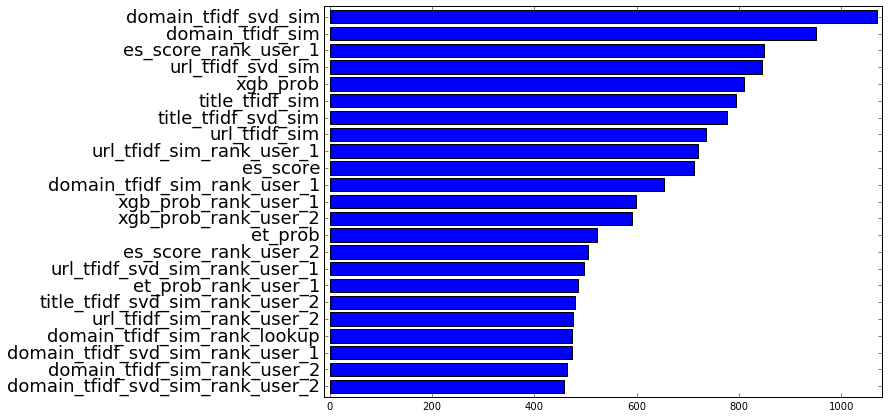

In [45]:
plt.figure(figsize=(10, 7))

fs, scores = zip(*fscore)

fs = np.array(fs)[::-1]
scores = np.array(scores)[::-1]

n = len(scores)
start = np.arange(n)
width = 0.35
plt.barh(start, scores)

plt.yticks(start + 0.4, fs, fontsize=18)

plt.margins(0.01)
plt.show()